## CMOA

****** ****** CMOA ****** ******
{'name': 'x_population', 'length': 10, 'sample': [3, 0, 3, 3, 1, 2, 3, 0, 1, 0]}
{'name': 'y_population', 'length': 10, 'sample': [[0.3861039654793861, 0.41339854444792945, 0.002946287289065514, 0.1975512027836189], [0.25347879500866444, 0.1630585874620713, 0.5555429487639095, 0.027919668765354656], [0.486708637338863, 0.11814978041250535, 0.1318796706247165, 0.26326191162391516], [0.15221740075245052, 0.160480374495776, 0.018682754224408953, 0.6686194705273645], [0.13370381166242384, 0.6683597814769309, 0.1553858721424756, 0.042550534718169705], [0.2452025166091389, 0.10717022028406939, 0.5665486854813044, 0.08107857762548736], [0.17957080801960365, 0.6120105329629821, 0.03678155993113963, 0.1716370990862746], [0.2366103096770779, 0.049473809078975195, 0.4019408649291961, 0.3119750163147507], [0.04335143670419308, 0.6780600276339278, 0.10074777930559509, 0.17784075635628405], [0.4891325256543114, 0.3728653255136693, 0.04624589563934058, 0.0917562531926

(0.0, 115.0)

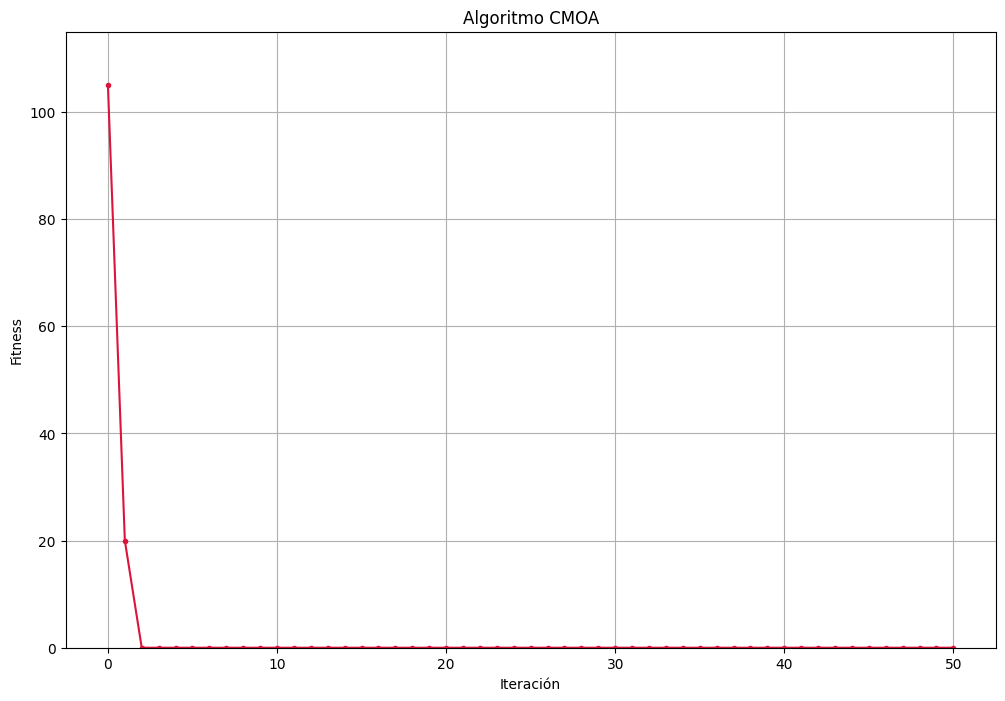

In [39]:
# # CMOA_Algorithm.py
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt

a = 0.01
b = 0.02
c = 0.06
d = 0.0
e = 1.70
f = 0.09

# Definición de las ecuaciones Lotka-Volterra
# Modelos de Lotka-Volterra (depredador-presa, competitivo, cooperativo)
def predator_prey(pop, t, a, b, c, d):
    x, y = pop  # x = plantas, z = hongos
    dxdt = x * (a - b * y)
    dzdt = y * (-c + d * x)
    return [dxdt, dzdt]


def competitive(pop, t, a, b, c, d, e, f):
    x, y = pop  # x = plantas, z = hongos
    dxdt = x * (a - b * x - c * y)
    dzdt = y * (d - e * x - f * y)
    return [dxdt, dzdt]


def cooperative(pop, t, a, b, c, d, e, f):
    x, y = pop  # x = plantas, z = hongos
    dxdt = x * (a - b * x + c * y)
    dzdt = y * (d + e * x - f * y)
    return [dxdt, dzdt]


# Función para resolver las ODEs
def solve_ODEs(model, y0, t, args):
    return odeint(model, y0, t, args=params)


# Inicialización de probabilidades
def initialize_probability_population(n_tasks, n_machines, population_size):
    return [
        [np.random.dirichlet(np.ones(n_machines)).tolist() for _ in range(n_tasks)]
        for _ in range(population_size)
    ]


# Generar asignaciones a partir de probabilidades
def generate_assignments_from_probabilities(probabilities):
    return [
        np.random.choice(len(task_probs), p=task_probs) for task_probs in probabilities
    ]


# Calcular el makespan
def calculate_makespan(assignments, task_durations, n_machines):
    machine_times = np.zeros(n_machines)
    for task_idx, machine_idx in enumerate(assignments):
        machine_times[machine_idx] += task_durations[task_idx]
    return np.max(machine_times)


# Evaluar el fitness de la población
def evaluate_fitness(y_population, task_durations, n_machines):
    fitness_scores = []
    for probabilities in y_population:
        assignments = generate_assignments_from_probabilities(probabilities)
        fitness_scores.append(
            calculate_makespan(assignments, task_durations, n_machines)
        )
    return fitness_scores


# Algoritmo CMOA
def CMOA_machine_assignment(
    task_durations, n_machines, population_size, max_iter, t_span, params
):
    n_tasks = len(task_durations)

    # Inicialización de la población
    y_population = initialize_probability_population(
        n_tasks, n_machines, population_size
    )
    x_population = [generate_assignments_from_probabilities(y) for y in y_population]
    print("****** ****** CMOA ****** ******")
    print(
        {
            "name": "x_population",
            "length": len(x_population),
            "sample": x_population[0],
        }
    )
    print(
        {
            "name": "y_population",
            "length": len(y_population),
            "sample": y_population[0],
        }
    )
    fitness_scores = [
        calculate_makespan(assignments, task_durations, n_machines)
        for assignments in x_population
    ]
    print("***  *** *** *** *** *** *** *** *** *** *** *** *** *** *** *** *** *** ")
    # Encontrar la mejor solución inicial
    best_fitness = min(fitness_scores)
    best_assignment = x_population[np.argmin(fitness_scores)]
    print(
        {
            "fitness_scores": fitness_scores,
            "best_fit": best_fitness,
            "best assig": best_assignment,
        }
    )

    # Historial de seguimiento
    fitness_history = [best_fitness]

    # Ciclo principal del algoritmo
    iteration = 0
    while iteration < max_iter:
        for i in range(population_size):
            # Generar nuevas probabilidades con Lotka-Volterra
            new_probabilities = []
            for task_probs in y_population[i]:
              print("task_probs: ", task_probs)
              # TODO: Hacer un random choice con los otros modelos
              model = random.choice([predator_prey, competitive, cooperative])

              # Simular ODEs para el individuo, para modelar el comportamiento de las poblaciones

              t = np.linspace(0, 100, 500)  # Tiempo de integración
              if model == predator_prey:
                params = (a, b, c, d)  # Parámetros del modelo depredador-presa
              elif model == competitive:
                params = (a, b, c, d, e, f)  # Parámetros del modelo competitivo
              else:
                params = (a, b, c, d, e, f)  # Parámetros del modelo cooperativo
                # Resolver ODEs para cada individuo
                updated_probs = solve_ODEs(model, task_probs[:2], t, args=params)[-1] # Último valor
                updated_probs = np.clip(updated_probs, 1e-6, None)
                updated_probs /= updated_probs.sum()  # Normalización
                new_probabilities.append(updated_probs.tolist())

            # Reemplazar y actualizar asignaciones
            print("new_probabilities")
            print(new_probabilities)
            y_population[i] = new_probabilities
            new_assignments = generate_assignments_from_probabilities(new_probabilities)
            new_fitness = calculate_makespan(
                new_assignments, task_durations, n_machines
            )
            print(new_fitness)

        # Si mejora, actualizar
        if new_fitness < fitness_scores[i]:
          x_population[i] = new_assignments
          fitness_scores[i] = new_fitness

        # Verificar si es la mejor global
        print(new_fitness, best_fitness)
        if new_fitness < best_fitness:
          best_fitness = new_fitness
          best_assignment = new_assignments

        # Registrar el mejor fitness por iteración
        fitness_history.append(best_fitness)
        iteration += 1

    return best_assignment, best_fitness, fitness_history


# Parámetros del problema
task_durations = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]
n_machines = 4
population_size = 10
max_iter = 50
t_span = np.linspace(0, 1, 100)
params = (1.5, 0.5, 0.2, 1.0, 0.3, 0.4)

# Ejecutar el algoritmo
best_assignment, best_fitness, fitness_history = CMOA_machine_assignment(
    task_durations, n_machines, population_size, max_iter, t_span, params
)

# Resultados
print("Mejor asignación:", best_assignment)
print("Mejor makespan:", best_fitness)
print("fitness_history:", fitness_history)


plt.figure(figsize=(12, 8))
plt.plot([i for i in range(len(fitness_history))], fitness_history,'o-',markersize=3, color="crimson")
plt.xlabel("Iteración")
plt.ylabel("Fitness")
plt.title("Algoritmo CMOA")
plt.grid()
plt.ylim(0, max(fitness_history) + 10)

## MOA con recocido simulado

num_machines: 4
num_tasks: 10
initial sol: [3, 1, 1, 3, 1, 2, 3, 3, 0, 3]
machine: 4 -> 20 ---- [0, 0, 0, 20]
machine: 2 -> 35 ---- [0, 35, 0, 20]
machine: 2 -> 15 ---- [0, 50, 0, 20]
machine: 4 -> 45 ---- [0, 50, 0, 65]
machine: 2 -> 30 ---- [0, 80, 0, 65]
machine: 3 -> 55 ---- [0, 80, 55, 65]
machine: 4 -> 25 ---- [0, 80, 55, 90]
machine: 4 -> 40 ---- [0, 80, 55, 130]
machine: 1 -> 50 ---- [50, 80, 55, 130]
machine: 4 -> 60 ---- [50, 80, 55, 190]
Iteración 100: Makespan actual = 135, Mejor makespan = 105, Temp = 59.44063490675698
Iteración 200: Makespan actual = 120, Mejor makespan = 100, Temp = 2.8265512624947022
Iteración 300: Makespan actual = 110, Mejor makespan = 100, Temp = 0.13440960131134455
Iteración 400: Makespan actual = 105, Mejor makespan = 100, Temp = 0.006391513631608326
Total worse accepted: 38.936 % of 89.25 %
Mejor solución encontrada (asignación de tareas a máquinas): [4, 4, 1, 3, 4, 3, 1, 2, 2, 1]
Distribucion de la carga: [100, 65, 105, 105]
Makespan mínimo estim

Text(0.5, 1.0, 'Recocido simulado')

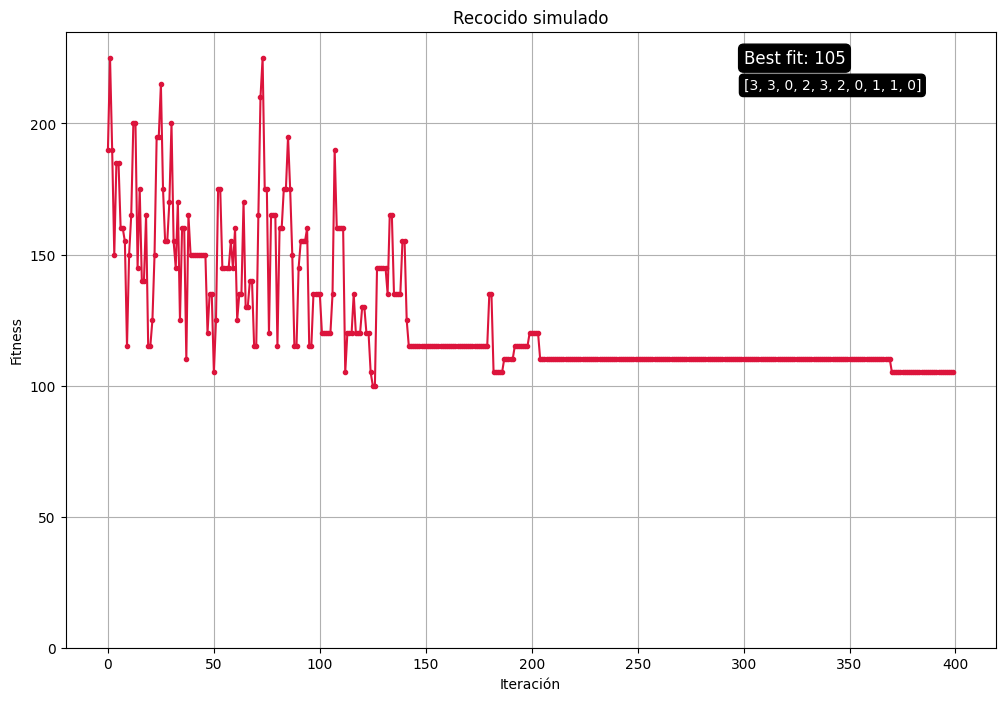

In [ ]:
# MOA_Recocido.py
import numpy as np
import random
import matplotlib.pyplot as plt

# Función de evaluación del makespan
def calculate_makespan(machine_loads):
    # print(f"max = {max(machine_loads)}")
    return max(machine_loads)


# # Asegurar al menos una tarea por máquina
# def generate_initial_solution(num_tasks, num_machines):
#     solution = []
#     for i in range(num_machines):
#         if i < num_tasks:
#             solution.append(i)
#     # Asignar las tareas restantes aleatoriamente
#     for _ in range(num_tasks - len(solution)):
#         solution.append(random.randint(0, num_machines - 1))
#     random.shuffle(solution)
#     print(f"solution: {solution}")
#     return solution


# Función para generar una solución inicial aleatoria
def generate_initial_solution(num_tasks, num_machines):
    print(f"num_machines: {num_machines}")
    print(f"num_tasks: {num_tasks}")
    init = [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
    print(f"initial sol: {init}")
    return init


# Función para generar un vecino (modificar la asignación de una tarea a otra máquina)
def generate_neighbor(solution, num_machines):
    new_solution = solution.copy()
    # print(f"old solution: {solution}")
    task_to_change = random.randint(0, len(solution) - 1)
    new_machine = random.randint(0, num_machines - 1)
    while new_machine == new_solution[task_to_change]:
        new_machine = random.randint(0, num_machines - 1)
    new_solution[task_to_change] = new_machine
    # print(f"solution fnl: {new_solution}")
    return new_solution


# Función para calcular la temperatura inicial para asegurar probabilidad del 90%
def calculate_initial_temperature(delta_e, p_initial):
    return -delta_e / np.log(p_initial)


best_sol = []


# Función principal del recocido simulado
def simulated_annealing(
    num_tasks, num_machines, task_times, initial_probability=0.9, max_iterations=400
):
    # Generar una solución inicial
    current_solution = generate_initial_solution(num_tasks, num_machines)
    current_machine_loads = [0] * num_machines  # [0, 0, 0, 0]
    for i, machine in enumerate(current_solution):
        current_machine_loads[machine] += task_times[i]
        print(f"machine: {machine+1} -> {task_times[i]} ---- {current_machine_loads}")
    current_makespan = calculate_makespan(current_machine_loads)

    # Calcular la temperatura inicial
    delta_e = 30  # Diferencia estimada entre soluciones iniciales
    # temperature = calculate_initial_temperature(delta_e, initial_probability)
    # print(f"temp: {temperature}")
    temperature = 1250

    # Parámetro de enfriamiento
    cooling_rate = 0.97

    best_solution = current_solution
    best_makespan = current_makespan

    # Variables para seguimiento
    accepted_worse_solutions = 0
    total_worse_solutions = 0
    accepted = []

    for iteration in range(max_iterations):
        # Generar una solución vecina
        neighbor_solution = generate_neighbor(current_solution, num_machines)
        neighbor_machine_loads = [0] * num_machines
        for i, machine in enumerate(neighbor_solution):
            neighbor_machine_loads[machine] += task_times[i]
        neighbor_makespan = calculate_makespan(neighbor_machine_loads)

        # Calcular diferencia de energía
        delta_makespan = neighbor_makespan - current_makespan

        # Aceptar solución vecina (criterio de Metropolis) si es mejor
        if delta_makespan < 0:  # Mejor solución
            current_solution = neighbor_solution
            current_makespan = neighbor_makespan
            current_machine_loads = neighbor_machine_loads

            # Actualizar la mejor solución
            if current_makespan < best_makespan:
                best_solution = current_solution
                best_makespan = current_makespan

        else:  # Peor solución
            total_worse_solutions += 1
            acceptance_probability = np.exp(-delta_makespan / temperature)
            if np.random.rand() < acceptance_probability:
                accepted.append(delta_makespan)
                current_solution = neighbor_solution
                current_makespan = neighbor_makespan
                current_machine_loads = neighbor_machine_loads
                accepted_worse_solutions += 1

        best_sol.append(current_makespan)
        # Reducir la temperatura
        temperature *= cooling_rate

        # Log iteración
        if (iteration + 1) % 100 == 0:
            print(
                f"Iteración {iteration+1}: Makespan actual = {current_makespan}, Mejor makespan = {best_makespan}, Temp = {temperature}"
            )

    print(
        f"Total worse accepted: {round( (accepted_worse_solutions/total_worse_solutions)*100,3)} % of {round((total_worse_solutions/max_iterations)*100,2)} %"
    )
    # Verificar porcentaje de aceptacion de peores soluciones
    # print(f"accepted on {len(accepted)}")
    # print(np.count_nonzero(accepted[0:100]) / len(accepted[0:100]))
    # print(np.count_nonzero(accepted[101:200]) / len(accepted[101:200]))
    # print(np.count_nonzero(accepted[201:300]) / len(accepted[201:300]))
    # print(np.count_nonzero(accepted[301:400]) / len(accepted[301:400]))

    return best_solution, best_makespan, current_machine_loads


# Parámetros del problema
num_machines = 4
task_times = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]
num_tasks = len(task_times)

# Ejecutar el recocido simulado
best_solution, best_makespan, machine_load = simulated_annealing(
    num_tasks, num_machines, task_times
)

# Imprimir resultados finales
print(
    f"Mejor solución encontrada (asignación de tareas a máquinas): {[i + 1 for i in best_solution]}"
)
print(f"Distribucion de la carga: {machine_load}")
print(f"Makespan mínimo estimado: {best_makespan}")


plt.figure(figsize=(12, 8))
plt.plot([i for i in range(400)], best_sol,'o-',markersize=3, color="crimson")
plt.grid()
plt.ylim(0, max(best_sol) + 10)
plt.text(
    300,
    max(best_sol) - 2,
    f"Best fit: {best_sol[len(best_sol)-1]}",
    color="white",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.text(
    300,
    max(best_sol) - 12,
    best_solution,
    color="white",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.xlabel("Iteración")
plt.ylabel("Fitness")
plt.title("Recocido simulado")
# plt.show()


## MOA con AA.GG

In [ ]:
# MOA_AAGG.py
import random
import os

clear = lambda: os.system("clear")
clear()


def inicializar_poblacion(num_tareas, num_machines, poblacion_size):
    poblacion = []
    for _ in range(poblacion_size):
        cromosoma = [random.randint(0, num_machines - 1) for _ in range(num_tareas)]
        poblacion.append(cromosoma)
    print(poblacion)
    return poblacion


def fitness(cromosoma, tiempos, num_machines):
    cargas = [0] * num_machines
    for tarea, maquina in enumerate(cromosoma):
        cargas[maquina] += tiempos[tarea]
    makespan = max(cargas)
    return 1 / (1 + makespan), makespan


def seleccion_ruleta(poblacion, fitnesses):
    total_fitness = sum(fitnesses)
    seleccion_prob = [f / total_fitness for f in fitnesses]
    return random.choices(poblacion, weights=seleccion_prob, k=2)


def crossover(padre1, padre2):
    punto = random.randint(1, len(padre1) - 1)
    hijo1 = padre1[:punto] + padre2[punto:]
    hijo2 = padre2[:punto] + padre1[punto:]
    return hijo1, hijo2


def mutacion(cromosoma, num_machines, tasa_mutacion=0.1):
    for i in range(len(cromosoma)):
        if random.random() < tasa_mutacion:
            cromosoma[i] = random.randint(0, num_machines - 1)
    return cromosoma


def algoritmo_genetico(
    tiempos,
    num_machines,
    num_tareas,
    poblacion_size=50,
    generaciones=100,
    tasa_mutacion=0.1,
):
    # Inicialización
    poblacion = inicializar_poblacion(num_tareas, num_machines, poblacion_size)
    mejores_makespan = []

    for generacion in range(generaciones):
        # Evaluar aptitudes
        fitnesses = [
            fitness(cromosoma, tiempos, num_machines)[0] for cromosoma in poblacion
        ]
        makespans = [
            fitness(cromosoma, tiempos, num_machines)[1] for cromosoma in poblacion
        ]
        mejores_makespan.append(min(makespans))

        nueva_poblacion = []
        while len(nueva_poblacion) < poblacion_size:
            # Selección
            padre1, padre2 = seleccion_ruleta(poblacion, fitnesses)

            # Cruce
            hijo1, hijo2 = crossover(padre1, padre2)

            # Mutación
            hijo1 = mutacion(hijo1, num_machines, tasa_mutacion)
            hijo2 = mutacion(hijo2, num_machines, tasa_mutacion)

            nueva_poblacion.extend([hijo1, hijo2])

        poblacion = nueva_poblacion[:poblacion_size]

    # Mejor solución final
    mejores_fitness = [
        fitness(cromosoma, tiempos, num_machines) for cromosoma in poblacion
    ]
    mejor_cromosoma = poblacion[mejores_fitness.index(max(mejores_fitness))]
    mejor_makespan = min(makespans)

    return mejor_cromosoma, mejor_makespan, mejores_makespan


num_machines = 4
num_tareas = 10
tiempos = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]

mejor_solucion, mejor_makespan, historial = algoritmo_genetico(
    tiempos,
    num_machines,
    num_tareas,
    poblacion_size=30,
    generaciones=500,
    tasa_mutacion=0.2,
)

print("Mejor asignación:", mejor_solucion)
print("Makespan mínimo:", mejor_makespan)


## MOA - Con tres modelos de ODE's


In [174]:
import random
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Lotka-Volterra equation parameters (adjust as needed)
a = 0.01  # Growth rate of prey
b = 0.02  # Predation rate
c = 0.06  # Death rate of predator
d = 0.0  # Growth rate of predator due to prey
e = 1.70
f = 0.09
def predator_prey(pop, t, a, b, c, d):
    x, y = pop  # x = prey, y = predator
    dxdt = x * (a - b * y)
    dydt = y * (-c + d * x)
    return [dxdt, dydt]

def competitive(pop, t, a, b, c, d, e, f):
    x, y = pop  # x = species 1, y = species 2
    dxdt = x * (a - b * x - c * y)
    dydt = y * (d - e * x - f * y)
    return [dxdt, dydt]

def cooperative(pop, t, a, b, c, d, e, f):
    x, y = pop  # x = species 1, y = species 2
    dxdt = x * (a - b * x + c * y)
    dydt = y * (d + e * x - f * y)
    return [dxdt, dydt]

def solve_odes(model, initial_conditions, t_span):
    """Solve the Lotka-Volterra equations using odeint."""
    if model == predator_prey:
        params = (a, b, c, d)
    elif model == competitive:
        params = (a, b, c, d, 0.3, 0.4)
    else:  # cooperative
        params = (a, b, c, d, 0.3, 0.4)
    solution = odeint(model, initial_conditions, t_span, args=params)
    return solution[-1]  # Return the final state

def mutate(chromosome, num_machines, model):
    """Mutate using Lotka-Volterra dynamics."""
    # Convert chromosome to initial conditions for Lotka-Volterra
    initial_conditions = [chromosome.count(i) for i in range(num_machines)]
    initial_conditions = [initial_conditions[0], sum(initial_conditions[1:])]  # Fixed to be: [x0, y0]
    # This initial conditions must be verified!!!!!!!!
    # print("initial_conditions: ",initial_conditions)
    # Solve the Lotka-Volterra equations
    new_state = solve_odes(model, initial_conditions, np.linspace(0, 1, 10))  # Adjust t_span if needed
    # Convert the new state back to a chromosome
    new_chromosome = []
    for i, count in enumerate(new_state):
        new_chromosome.extend([i] * int(count))
    # Handle rounding errors by adding/removing elements
    while len(new_chromosome) < len(chromosome):
        new_chromosome.append(random.randint(0, num_machines - 1))
    while len(new_chromosome) > len(chromosome):
        new_chromosome.pop(random.randint(0, len(new_chromosome) - 1))
    return new_chromosome


def initialize_population(num_tasks, num_machines, population_size):
    """Initialize a population of random solutions."""
    population = []
    for _ in range(population_size):
        chromosome = [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
        population.append(chromosome)
    return population

def calculate_makespan(chromosome, task_times, num_machines):
    """Calculate the makespan for a given solution."""
    machine_loads = [0] * num_machines
    for task_index, machine_index in enumerate(chromosome):
        machine_loads[machine_index] += task_times[task_index]
    return max(machine_loads)



def moa(task_times, num_machines, population_size, max_iterations):
    """Run the Mycorrhiza Optimization Algorithm."""
    population = initialize_population(len(task_times), num_machines, population_size)
    # print("population:")
    # print(population)
    best_solution = random.choice(population)
    best_makespan = calculate_makespan(best_solution, task_times, num_machines)

    # List to store best makespan values for each iteration
    best_makespans_history = [best_makespan]

    iteration = 0
    while iteration < max_iterations:
        for i in range(population_size):
            # Randomly choose a Lotka-Volterra model
            model = random.choice([predator_prey, competitive, cooperative])

            # Update solution using Lotka-Volterra dynamics (mutation-like)
            new_solution = mutate(population[i], num_machines, model)
            print(f"new_solution: {new_solution}")
            # Calculate makespan for the new solution
            new_makespan = calculate_makespan(new_solution, task_times, num_machines)

            # Update best solution if necessary
            if new_makespan < best_makespan:
                best_makespan = new_makespan
                best_solution = new_solution

            if new_makespan < best_makespan:
              best_makespan = new_makespan
              best_solution = new_solution

            # Replace the current solution in the population
            population[i] = new_solution

        best_makespans_history.append(best_makespan)
        iteration += 1

    return best_solution, best_makespan,best_makespans_history


# Example usage:
task_times = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]
num_machines = 4
population_size = 20
num_iterations = 100


all_solutions = []  # Lista para almacenar las soluciones de todas las iteraciones
mean = []
under = []
above=[]
for j in range(1):
  print(f"Iteration {j+1}")
  for i in range(2):
    best_solution, best_makespan, best_makespans_history = moa(task_times, num_machines, population_size, num_iterations)
    # print("Best solution:", best_solution)
    # print("Best makespan:", best_makespan)
    all_solutions.append(best_makespan)
    # print("all_solutions: ",all_solutions)

  # Convertir a un array de numpy para facilitar el procesamiento
  # print("all_solutions= ",all_solutions)
  all_solutionss = np.array(all_solutions)
  # print(type(all_solutions))
  # Promedio de las soluciones
  average_solution = np.mean(all_solutionss)
  # print("Average solution:", average_solution)
  # Envolvente (máximo y mínimo en cada paso de tiempo)
  envelope_upper = np.max(all_solutionss, axis=0)
  envelope_lower = np.min(all_solutionss, axis=0)
  # print("Upper envelope:", envelope_upper)
  # print("Lower envelope:", envelope_lower)
  mean.append(average_solution)
  under.append(envelope_lower)
  above.append(envelope_upper)


Iteration 1
new_solution: [0, 0, 0, 1, 1, 1, 0, 1, 0, 2]
new_solution: [0, 0, 0, 0, 1, 1, 1, 3, 2, 0]
new_solution: [0, 1, 1, 2, 3, 0, 1, 2, 3, 3]
new_solution: [0, 0, 0, 1, 1, 1, 2, 2, 2, 2]
new_solution: [0, 1, 1, 1, 1, 1, 1, 1, 0, 2]
new_solution: [0, 1, 1, 1, 1, 1, 1, 1, 2, 3]
new_solution: [0, 0, 0, 1, 1, 1, 1, 1, 3, 2]
new_solution: [1, 0, 3, 0, 2, 3, 1, 1, 3, 3]
new_solution: [0, 0, 1, 1, 0, 1, 0, 3, 1, 3]
new_solution: [0, 0, 0, 0, 0, 1, 1, 1, 3, 0]
new_solution: [0, 0, 0, 1, 1, 1, 1, 0, 3, 3]
new_solution: [1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
new_solution: [1, 0, 1, 0, 1, 2, 0, 2, 2, 3]
new_solution: [1, 2, 1, 1, 3, 1, 1, 2, 1, 1]
new_solution: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
new_solution: [0, 1, 1, 1, 3, 3, 0, 1, 0, 2]
new_solution: [0, 1, 1, 1, 0, 3, 2, 0, 3, 1]
new_solution: [1, 1, 3, 3, 3, 1, 0, 3, 2, 2]
new_solution: [0, 0, 1, 3, 2, 3, 2, 0, 1, 0]
new_solution: [0, 0, 0, 0, 2, 3, 0, 3, 1, 0]
new_solution: [0, 0, 0, 0, 3, 0, 2, 2, 2, 3]
new_solution: [0, 0, 0, 0, 0, 1, 1, 1, 1, 2

100
115


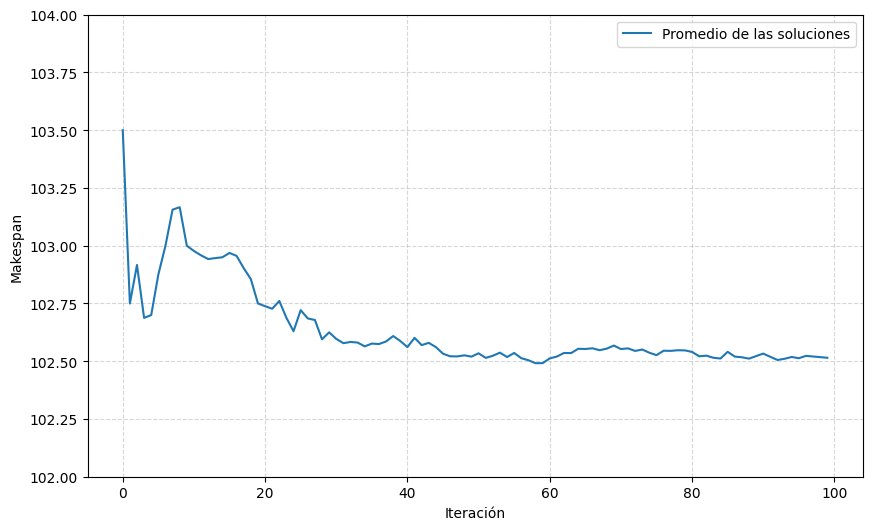

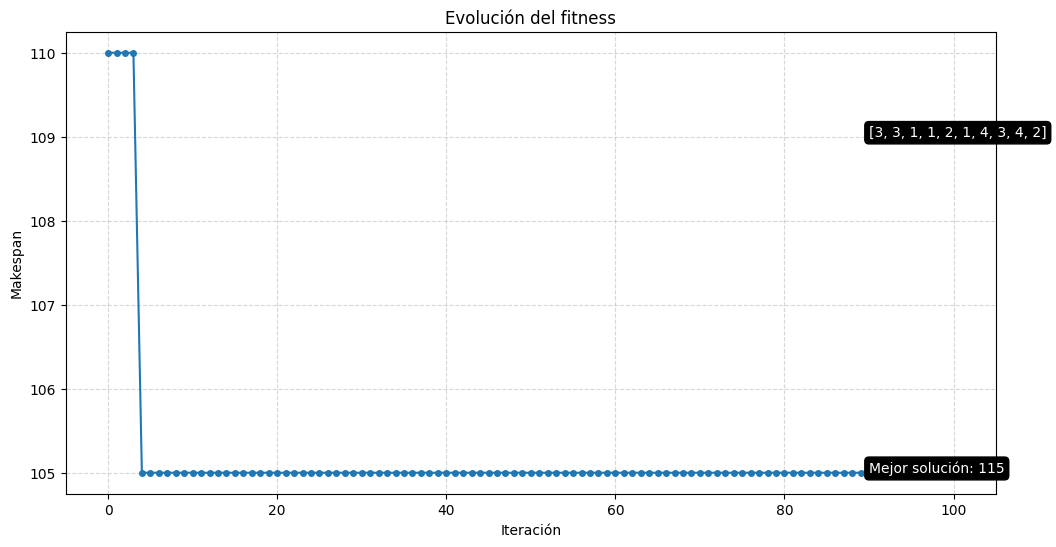

In [167]:
print(len(mean))
print(best_makespan)
# Graficar el promedio y la envolvente
plt.figure(figsize=(10, 6))

# Promedio
x = [i for i in range(len(mean))]
plt.plot(x,mean, markersize=4,label="Promedio de las soluciones")
# # Envolvente superior
# plt.fill_between(x,above,under, color='gray', alpha=0.25, label="Envolvente")
# plt.fill_between([i for i in range(len(mean))],under, color='gray', alpha=0.5, label="Envolvente")

# Etiquetas y título
# plt.title("Envolvente Promedio de las Soluciones de Lotka-Volterra")
plt.xlabel("Iteración")
plt.ylabel("Makespan")
plt.legend()
ax = plt.gca()
ax.set_ylim([102, 104])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



task_per_machine = []
for i in best_solution:
    task_per_machine.append(i+1)

 # Plot the best makespan history
plt.figure(figsize=(12, 6))
plt.plot(best_makespans_history, 'o-', markersize=4)
plt.xlabel("Iteración")
plt.ylabel("Makespan")
plt.title("Evolución del fitness")
plt.grid(True, alpha=0.5,linestyle='--')
plt.text(
    num_iterations-10,
    max(best_makespans_history)-1,
    task_per_machine,
    color="white",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.text(
    num_iterations-10,
    max(best_makespans_history)-5,
    f"Mejor solución: {best_makespan}",
    color="white",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.show()

In [158]:
import numpy as np
import random
from scipy.integrate import odeint


def update_x_with_y(x, y, num_machines):
    """
    Actualiza las soluciones x basándose en los valores de influencia y.

    Args:
        x (list): Solución actual (asignaciones).
        y (list): Vector de influencias asociado.
        num_machines (int): Número de máquinas.

    Returns:
        list: Nueva solución actualizada.
    """
    new_x = []
    for task, influence in zip(x, y):
        if random.random() < influence:  # Probabilidad basada en influencia
            new_machine = random.randint(0, num_machines - 1)  # Cambiar de máquina
            new_x.append(new_machine)
        else:
            new_x.append(task)  # Mantener la asignación actual
    return new_x


# Función objetivo: calcular el makespan
def calculate_makespan(assignments, task_durations, num_machines):
    """
    Calcula el makespan para una asignación de tareas.

    Args:
        assignments (list): Asignación de tareas a máquinas.
        task_durations (list): Tiempos de procesamiento de cada tarea.
        num_machines (int): Número de máquinas.

    Returns:
        float: Makespan (tiempo máximo).
    """
    machine_times = [0] * num_machines
    for task_idx, machine_idx in enumerate(assignments):
        machine_times[machine_idx] += task_durations[task_idx]
    return max(machine_times)

# Inicializar población
def initialize_population(num_tasks, num_machines, population_size):
    """
    Inicializa una población de soluciones y valores auxiliares.

    Args:
        num_tasks (int): Número de tareas.
        num_machines (int): Número de máquinas.
        population_size (int): Tamaño de la población.

    Returns:
        tuple: Poblaciones de soluciones (x) y valores auxiliares (y).
    """
    x_population = [
        [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
        for _ in range(population_size)
    ]
    y_population = [
        [random.random() for _ in range(num_tasks)]
        for _ in range(population_size)
    ]
    return x_population, y_population

# Modelos Lotka-Volterra
def predator_prey(y, t):
    x, z = y
    dxdt = x * (0.61 - 0.02 * z)
    dzdt = z * (-0.1 + 0.1 * x)
    return [dxdt, dzdt]

def competitive(y, t):
    x, z = y
    dxdt = x * (0.1 - 0.02 * x - 0.1 * z)
    dzdt = z * (0.01 - 0.02 * x - 0.02 * z)
    return [dxdt, dzdt]

def cooperative(y, t):
    x, z = y
    dxdt = x * (0.1 - 0.2 * x + 0.1 * z)
    dzdt = z * (0.01 + 0.2 * x - 0.02 * z)
    return [dxdt, dzdt]

def apply_lotka_volterra(y, model, t_span):
    """
    Aplica las ecuaciones de Lotka-Volterra para actualizar el vector y.

    Args:
        y (list): Vector de influencias inicial.
        model (function): Modelo de Lotka-Volterra.
        t_span (numpy.ndarray): Intervalo de tiempo para resolver las ODEs.

    Returns:
        list: Nuevo vector de influencias ajustado.
    """
    new_y = []
    for value in y:
        # Resolver ODE para cada influencia individual
        solution = odeint(model, [value, value], t_span)
        final_value = solution[-1][0]  # Tomar la primera variable como nueva influencia
        new_y.append(max(0.1, min(2, final_value)))  # Restringir valores entre 0.1 y 2
    return new_y

# MOA Principal
def mycorrhiza_optimization(num_tasks, num_machines, task_durations, population_size, max_iter):
    """
    Algoritmo de Optimización Mycorrhiza (MOA) con influencias.

    Args:
        num_tasks (int): Número de tareas.
        num_machines (int): Número de máquinas.
        task_durations (list): Tiempos de procesamiento de las tareas.
        population_size (int): Tamaño de la población.
        max_iter (int): Número máximo de iteraciones.

    Returns:
        list: Mejor solución encontrada.
    """
    # Inicializar población
    x_population, y_population = initialize_population(num_tasks, num_machines, population_size)

    # Evaluar el fitness inicial
    fitness_values = [calculate_makespan(x, task_durations, num_machines) for x in x_population]
    best_solution = x_population[np.argmin(fitness_values)]
    best_fitness = min(fitness_values)

    t_span = np.linspace(0, 1, 10)  # Intervalo de tiempo para las ODEs

    for iteration in range(max_iter):
        for i in range(population_size):
            # Seleccionar un modelo de Lotka-Volterra aleatorio
            model = random.choice([predator_prey, competitive, cooperative])

            # Actualizar y usando Lotka-Volterra
            y_population[i] = apply_lotka_volterra(y_population[i], model, t_span)

            # Actualizar x usando las influencias y
            x_population[i] = update_x_with_y(x_population[i], y_population[i], num_machines)

        # Recalcular el fitness
        fitness_values = [calculate_makespan(x, task_durations, num_machines) for x in x_population]

        # Actualizar mejor solución
        current_best_fitness = min(fitness_values)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = x_population[np.argmin(fitness_values)]

        print(f"Iteración {iteration+1}: Mejor Fitness = {best_fitness}")

    return best_solution, best_fitness



# Parámetros del problema
num_tasks = 10
num_machines = 4
task_durations = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]
population_size = 20
max_iter = 100

# Ejecutar el MOA
best_solution, best_fitness = mycorrhiza_optimization(
    num_tasks, num_machines, task_durations, population_size, max_iter
)

print("Mejor solución encontrada:", best_solution)
print("Mejor makespan:", best_fitness)


Iteración 1: Mejor Fitness = 120
Iteración 2: Mejor Fitness = 110
Iteración 3: Mejor Fitness = 110
Iteración 4: Mejor Fitness = 110
Iteración 5: Mejor Fitness = 110
Iteración 6: Mejor Fitness = 105
Iteración 7: Mejor Fitness = 105
Iteración 8: Mejor Fitness = 105
Iteración 9: Mejor Fitness = 105
Iteración 10: Mejor Fitness = 105
Iteración 11: Mejor Fitness = 105
Iteración 12: Mejor Fitness = 105
Iteración 13: Mejor Fitness = 105
Iteración 14: Mejor Fitness = 105
Iteración 15: Mejor Fitness = 105
Iteración 16: Mejor Fitness = 105
Iteración 17: Mejor Fitness = 105
Iteración 18: Mejor Fitness = 105
Iteración 19: Mejor Fitness = 105
Iteración 20: Mejor Fitness = 105
Iteración 21: Mejor Fitness = 100
Iteración 22: Mejor Fitness = 100
Iteración 23: Mejor Fitness = 100
Iteración 24: Mejor Fitness = 100
Iteración 25: Mejor Fitness = 100
Iteración 26: Mejor Fitness = 100
Iteración 27: Mejor Fitness = 100
Iteración 28: Mejor Fitness = 100
Iteración 29: Mejor Fitness = 100
Iteración 30: Mejor Fit

In [166]:
import numpy as np
from scipy.integrate import odeint
import random

# Función para calcular el makespan
def calculate_makespan(solution, task_times, num_machines):
    """
    Calcula el makespan para una asignación de tareas.

    Args:
        solution (list): Asignación de tareas a máquinas.
        task_times (list): Tiempos de procesamiento de cada tarea.
        num_machines (int): Número de máquinas.

    Returns:
        float: Makespan (tiempo máximo).
    """
    machine_loads = [0] * num_machines
    for task_idx, machine_idx in enumerate(solution):
        machine_loads[machine_idx] += task_times[task_idx]
    return max(machine_loads)

# Inicializar la población
def initialize_population(pop_size, num_tasks, num_machines):
    """
    Inicializa una población de soluciones.

    Args:
        pop_size (int): Tamaño de la población.
        num_tasks (int): Número de tareas.
        num_machines (int): Número de máquinas.

    Returns:
        list: Población inicial (lista de soluciones).
    """
    return [
        [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
        for _ in range(pop_size)
    ]

# Modelos Lotka-Volterra
def predator_prey(y, t, a, b, c, d):
    x, z = y
    dxdt = x * (a - b * z)
    dzdt = z * (-c + d * x)
    return [dxdt, dzdt]

def competitive(y, t, a, b, c, d, e, f):
    x, z = y
    dxdt = x * (a - b * x - c * z)
    dzdt = z * (d - e * x - f * z)
    return [dxdt, dzdt]

def cooperative(y, t, a, b, c, d, e, f):
    x, z = y
    dxdt = x * (a - b * x + c * z)
    dzdt = z * (d + e * x - f * z)
    return [dxdt, dzdt]

# Resolver las ODEs para un modelo dado
def solve_ode(model, initial_conditions, t_span, params):
    return odeint(model, initial_conditions, t_span, args=params)[-1]

# Algoritmo CMOA
def cmoa(task_times, num_tasks, num_machines, pop_size, max_iter, a, b, c, d, e, f):
    """
    Algoritmo de Optimización Mycorrhiza (CMOA).

    Args:
        task_times (list): Tiempos de procesamiento de las tareas.
        num_tasks (int): Número de tareas.
        num_machines (int): Número de máquinas.
        pop_size (int): Tamaño de la población.
        max_iter (int): Número máximo de iteraciones.
        a, b, c, d, e, f (float): Parámetros de los modelos Lotka-Volterra.

    Returns:
        tuple: Mejor solución y su makespan.
    """
    # Inicializar población
    population = initialize_population(pop_size, num_tasks, num_machines)
    best_solution = None
    best_makespan = float('inf')

    # Evaluar la población inicial
    fitness = [calculate_makespan(ind, task_times, num_machines) for ind in population]
    for i, fit in enumerate(fitness):
        if fit < best_makespan:
            best_makespan = fit
            best_solution = population[i]

    t_span = np.linspace(0, 1, 100)  # Intervalo de tiempo para las ODEs

    # Iteraciones principales del algoritmo
    for t in range(max_iter):
        for i in range(pop_size):
            # Seleccionar un modelo al azar
            rand = random.randint(1, 3)
            if rand == 1:
                model = predator_prey
                params = (a, b, c, d)
            elif rand == 2:
                model = competitive
                params = (a, b, c, d, e, f)
            else:
                model = cooperative
                params = (a, b, c, d, e, f)

            # Aplicar el modelo Lotka-Volterra
            avg_x = np.mean(population[i])  # Promedio de la solución actual
            avg_y = best_makespan  # Mejor makespan hasta ahora
            new_x, new_y = solve_ode(model, [avg_x, avg_y], t_span, params)

            # Crear una nueva solución basada en x (planta)
            new_solution = [
                (task + int(new_x)) % num_machines for task in population[i]
            ]

            # Evaluar la nueva solución
            new_fit = calculate_makespan(new_solution, task_times, num_machines)

            # Actualizar si es mejor
            if new_fit < fitness[i]:
                population[i] = new_solution
                fitness[i] = new_fit

                # Actualizar la mejor solución global
                if new_fit < best_makespan:
                    best_makespan = new_fit
                    best_solution = new_solution

        print(f"Iteración {t + 1}: Mejor makespan = {best_makespan}")

    return best_solution, best_makespan

# Ejemplo de uso
task_times = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]  # Tiempos de las tareas
num_tasks = len(task_times)  # Número de tareas
num_machines = 4  # Número de máquinas
pop_size = 20  # Tamaño de la población
max_iter = 50  # Número máximo de iteraciones

# Parámetros de Lotka-Volterra
a, b, c, d, e, f = 0.51, 0.52, 0.03, 0.04, 1.25, 0.06

# Ejecutar el algoritmo
best_solution, best_makespan = cmoa(
    task_times, num_tasks, num_machines, pop_size, max_iter, a, b, c, d, e, f
)

print("Mejor solución encontrada:", best_solution)
print("Mejor makespan:", best_makespan)


Iteración 1: Mejor makespan = 115
Iteración 2: Mejor makespan = 115
Iteración 3: Mejor makespan = 115
Iteración 4: Mejor makespan = 115
Iteración 5: Mejor makespan = 115
Iteración 6: Mejor makespan = 115
Iteración 7: Mejor makespan = 115
Iteración 8: Mejor makespan = 115
Iteración 9: Mejor makespan = 115
Iteración 10: Mejor makespan = 115
Iteración 11: Mejor makespan = 115
Iteración 12: Mejor makespan = 115
Iteración 13: Mejor makespan = 115
Iteración 14: Mejor makespan = 115
Iteración 15: Mejor makespan = 115
Iteración 16: Mejor makespan = 115
Iteración 17: Mejor makespan = 115
Iteración 18: Mejor makespan = 115
Iteración 19: Mejor makespan = 115
Iteración 20: Mejor makespan = 115
Iteración 21: Mejor makespan = 115
Iteración 22: Mejor makespan = 115
Iteración 23: Mejor makespan = 115
Iteración 24: Mejor makespan = 115
Iteración 25: Mejor makespan = 115
Iteración 26: Mejor makespan = 115
Iteración 27: Mejor makespan = 115
Iteración 28: Mejor makespan = 115
Iteración 29: Mejor makespan 

## Aplicacion a Rastringin

Iteración 1: Mejor Fitness = 113.57669248567356
Iteración 2: Mejor Fitness = 113.57669248567356
Iteración 3: Mejor Fitness = 113.57669248567356
Iteración 4: Mejor Fitness = 113.57669248567356
Iteración 5: Mejor Fitness = 113.57669248567356
Iteración 6: Mejor Fitness = 113.57669248567356
Iteración 7: Mejor Fitness = 113.57669248567356
Iteración 8: Mejor Fitness = 113.57669248567356
Iteración 9: Mejor Fitness = 113.57669248567356
Iteración 10: Mejor Fitness = 113.57669248567356
Iteración 11: Mejor Fitness = 113.57669248567356
Iteración 12: Mejor Fitness = 113.57669248567356
Iteración 13: Mejor Fitness = 113.57669248567356
Iteración 14: Mejor Fitness = 113.57669248567356
Iteración 15: Mejor Fitness = 113.57669248567356
Iteración 16: Mejor Fitness = 113.57669248567356
Iteración 17: Mejor Fitness = 113.57669248567356
Iteración 18: Mejor Fitness = 113.57669248567356
Iteración 19: Mejor Fitness = 113.57669248567356
Iteración 20: Mejor Fitness = 113.57669248567356
Iteración 21: Mejor Fitness =

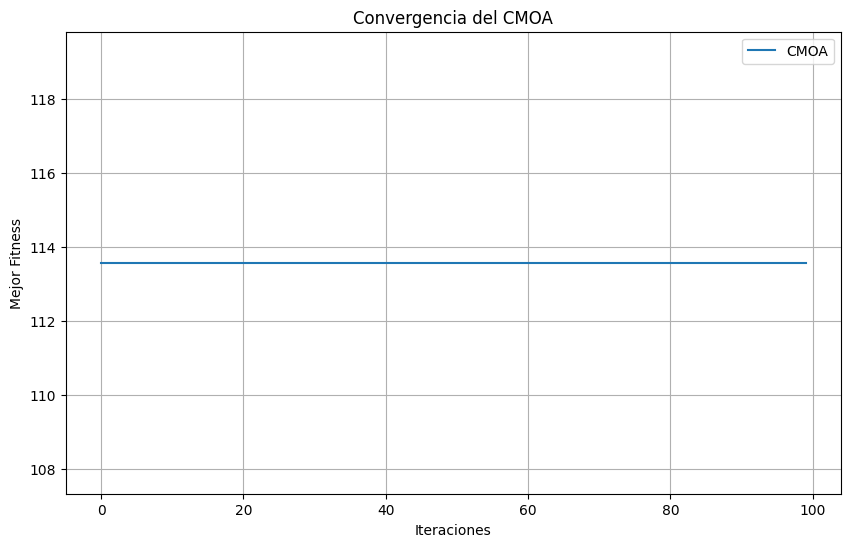

Mejor solución encontrada: [-1.01841862  2.99615288  2.96005733 -4.0443235   2.76037851  2.57096493
 -0.10724705  2.06108058  2.53921171  1.05722217]
Mejor fitness: 113.57669248567356


In [173]:
import numpy as np
from scipy.integrate import odeint
import random
import matplotlib.pyplot as plt

# Definir la función objetivo: Rastrigin
def rastrigin(x):
    A = 10
    return A * len(x) + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Modelos de Lotka-Volterra
def predator_prey(y, t, a, b, c, d):
    x, z = y
    dxdt = x * (a - b * z)
    dzdt = z * (-c + d * x)
    return [dxdt, dzdt]

def competitive(y, t, a, b, c, d):
    x, z = y
    dxdt = x * (a - b * x - c * z)
    dzdt = z * (d - b * z - c * x)
    return [dxdt, dzdt]

def cooperative(y, t, a, b, c, d):
    x, z = y
    dxdt = x * (a - b * x + c * z)
    dzdt = z * (d + b * x - c * z)
    return [dxdt, dzdt]

# Resolver las ODEs
def solve_odes(model, y0, t, params):
    return odeint(model, y0, t, args=params)[-1]

# Generar una población inicial
def initialize_population(pop_size, dim, bounds):
    return [np.random.uniform(bounds[0], bounds[1], dim) for _ in range(pop_size)]

# Evaluar el fitness de la población
def evaluate_population(population):
    return [rastrigin(ind) for ind in population]

# Aplicar las dinámicas Lotka-Volterra
def apply_lotka_volterra(ind, params, t_span):
    x0 = np.mean(ind)  # Promedio del individuo como población inicial
    y0 = np.std(ind)   # Desviación estándar como segunda población
    model = random.choice([predator_prey, competitive, cooperative])
    new_state = solve_odes(model, [x0, y0], t_span, params)
    # Modificar el individuo con los nuevos valores de x y z
    mod_factor = new_state[0] / (x0 + 1e-6)  # Evitar división por cero
    return np.clip(ind * mod_factor, -5.12, 5.12)

# Parámetros del algoritmo
pop_size = 20
dim = 10
bounds = [-5.12, 5.12]
max_iter = 100
params_lv = (0.1, 0.02, 0.03, 0.04)  # (a, b, c, d) para Lotka-Volterra
t_span = np.linspace(0, 1, 10)

# Inicializar población
population = initialize_population(pop_size, dim, bounds)
fitness = evaluate_population(population)

# Variables para seguimiento
best_fitness = []
best_solution = None
min_fitness = float('inf')

# Iteraciones del algoritmo
for iteration in range(max_iter):
    new_population = []
    for ind in population:
        new_ind = apply_lotka_volterra(ind, params_lv, t_span)
        new_population.append(new_ind)

    # Evaluar la nueva población
    new_fitness = evaluate_population(new_population)

    # Actualizar población y fitness
    for i in range(pop_size):
        if new_fitness[i] < fitness[i]:  # Solo aceptar soluciones mejores
            population[i] = new_population[i]
            fitness[i] = new_fitness[i]

    # Encontrar el mejor individuo
    current_best = min(fitness)
    if current_best < min_fitness:
        min_fitness = current_best
        best_solution = population[np.argmin(fitness)]

    best_fitness.append(min_fitness)
    print(f"Iteración {iteration + 1}: Mejor Fitness = {min_fitness}")

# Graficar la convergencia
plt.figure(figsize=(10, 6))
plt.plot(best_fitness, label="CMOA")
plt.xlabel("Iteraciones")
plt.ylabel("Mejor Fitness")
plt.title("Convergencia del CMOA")
plt.legend()
plt.grid()
plt.show()

# Resultados finales
print(f"Mejor solución encontrada: {best_solution}")
print(f"Mejor fitness: {min_fitness}")
